In [4]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_style('ticks', {"axes.linewidth": "1",'axes.yaxis.grid':False})
current_palette = sns.color_palette()

In [5]:
import sys
from rnn_analysis import utils, data_utils
from scipy.stats import pearsonr

import numpy as np
import pickle as pk
import pandas as pd

figoutpath = '/om/user/rishir/figs/mpong/rnn_dynamics/'
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
pd.set_option('mode.chained_assignment', None)

In [6]:

summary_fn = '/om/user/rishir/lib/MentalPong/dat_regularized/comparison_summary_pred.pkl'
df_reg, df_model_reg, df_primate_reg = data_utils.load__comparison_summary_df(fn=summary_fn, output_rep='pred')
df_reg['loss_weight_type'] = 'mov_smooth'
df_reg = df_reg[np.isfinite(df_reg['regularization_weight_simplicity_DS2'])].reset_index(drop=True)

df_base, df_model_base, df_primate = data_utils.load__comparison_summary_df()

loss_oi = 'vis-sim-mov'
df_base_pruned = df_base.query('loss_weight_type == "%s"' % loss_oi)
df_merged = pd.concat([df_base_pruned, df_reg])
df_all = pd.concat([df_base, df_reg])


In [12]:
def plot_least_square_line(x,y,ax):
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 'k:')
    return

def calculate_corr_all(df):
    df = df.dropna()._get_numeric_data()

    dfcols = pd.DataFrame(columns=df.columns)
    rho_values = dfcols.transpose().join(dfcols, how='outer')
    p_values = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            r_,p_ = pearsonr(df[r], df[c])
            rho_values[r][c] = r_
            p_values[r][c] = p_
    return rho_values, p_values


def plot_scatter_vs_consistency(df_, consistency_metrics, predictor_metrics, 
                                suffix='', flip_x_axis=False):
    for cons_metricn in consistency_metrics:
        for x_metricn in predictor_metrics:
            f,axes = plt.subplots(1,1,figsize=(4,5))
            ax = axes
            sns.scatterplot(data=df_, x=x_metricn, y=cons_metricn,
                            hue="loss_weight_type", style="rnn_type", 
                            ax=ax, legend='brief');

            ax.axhline(np.nanmean(df_primate[cons_metricn]), 
                       linestyle='--', color='k')
            plot_least_square_line(df_[x_metricn], 
                                   df_[cons_metricn], ax)
            ax.set_ylim([0,1])
            M = df_[x_metricn].max()*1.1
            m = df_[x_metricn].min()*0.9
            if flip_x_axis:
                ax.set_xlim([M,m])
            else:
                ax.set_xlim([m,M])                
            sns.despine(ax=ax, offset=10, trim=False)
            plt.tight_layout()
            if suffix is not None:
                f.savefig('%s/scatter_v2_%s_%s_%s.pdf' % (figoutpath, x_metricn, cons_metricn, suffix))
    return f,axes

def plot_variance_exp_of_consistency(df_, cons_metrics, predictor_metrics,
                                     square_correlation=True,
                                     suffix=None, plot_full_r2=False,
                                     plot_xlabels=False, ):
    x_size = np.max([np.min([len(predictor_metrics)*0.33, 12]),5])
    y_size = 5
    if plot_xlabels:
        y_size = 8
    f,axes = plt.subplots(2,1,figsize=(x_size,y_size))
    cols = ['#ff00aa', '#00aaff']

    for ci, cons_metric in enumerate(cons_metrics):
        ax = axes[ci]
        fks = [cons_metric] + predictor_metrics
        df_for_corr = df_[fks]
        rho_raw, p_ = calculate_corr_all(df_for_corr)
        
        if square_correlation:
            r2_raw = rho_raw[cons_metric]**2
        else:
            r2_raw = rho_raw[cons_metric]
            
        t_p = p_[cons_metric]<0.1
        print_df = pd.concat((r2_raw[t_p], p_[cons_metric][t_p]), axis=1)
#         print(print_df)

        tmp = np.array(df_for_corr)
        rho_partial, p_partial = utils.partial_corr(tmp, add_offset=True, return_pval=True)
        rho_partial, p_partial = rho_partial[0], p_partial[0]
        if square_correlation:
            r2_partial = rho_partial**2
        else:
            r2_partial = rho_partial
        
#         print('r2_partial')
#         print(r2_partial, p_partial)

        plot_vals = [i for i in range(len(fks)) if i!=0]
        ax.bar(plot_vals, r2_raw[plot_vals], width=0.3, color=cols[0])
        ax.bar([i+.3 for i in plot_vals], r2_partial[plot_vals], width=0.3, color=cols[1])
#         print(r2_raw[plot_vals], r2_partial[plot_vals])
        sns.despine(ax=ax, offset=10, trim=False)
        ax.set_title(cons_metric)
        if (ci == len(cons_metrics)-1) and plot_xlabels:
            ax.set_xticks([i+.15 for i in plot_vals])
            ax.set_xticklabels(predictor_metrics, rotation=90)
        
        if plot_full_r2:
            X = np.array(df_[predictor_metrics])
            y = np.array(df_[[cons_metric]])
            r2 = utils.get_R2_highD(y, X, k_folds=20, cross_validate_regression=False)
            if square_correlation is False:
                r2 = r2 ** 0.5
            ax.axhline(r2, linestyle='--',
                       linewidth=0.5, color=[0.5, 0.5, 0.5])
            print('full r2: %2.2f' % r2)

    plt.tight_layout()
    if suffix is not None:
        f.savefig('%s/consistency_variance_v2_exp_%s.pdf' % (figoutpath, suffix))
        return
    else:
        return f


/home/rishir/envs/py36/lib/python3.6/site-packages/seaborn/categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


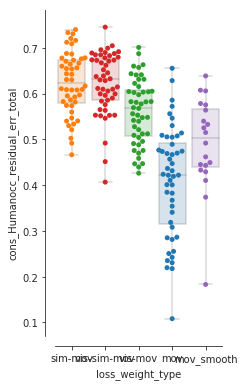

In [8]:
f,axes = plt.subplots(1,1,figsize=(3,6))
alpha = 0.2
palette_reordered = [current_palette[1], current_palette[3],
                     current_palette[2],current_palette[0],
                     current_palette[4]]
sns.boxplot(x="loss_weight_type", y="cons_Humanocc_residual_err_total", 
            data=df_all, ax=axes,whis=100, palette=palette_reordered,
            boxprops=dict(alpha=alpha), capprops=dict(alpha=alpha), 
            whiskerprops=dict(alpha=alpha), medianprops=dict(alpha=alpha),
                   order=['sim-mov', 'vis-sim-mov', 'vis-mov', 'mov', 'mov_smooth'])



sns.swarmplot(x="loss_weight_type", y="cons_Humanocc_residual_err_total", 
               data=df_all, ax=axes, palette=palette_reordered,
                   order=['sim-mov', 'vis-sim-mov', 'vis-mov', 'mov', 'mov_smooth'])
sns.despine(ax=axes, offset=10, trim=False)
f.savefig('%s/regularization_swarmplot.pdf' % figoutpath)

In [11]:
from scipy.stats import ttest_ind
from scipy.stats.mstats import kruskalwallis

for cfn in ['cons_Humanocc_residual_err_total', 'cons_Monkeyocc_residual_err_total']:
    print('%s : ' % cfn)
    for ss in ['sim-mov', 'mov']:
        x1 = np.array(df_all.query('loss_weight_type == "%s"' % ss)[cfn])
        x2 = np.array(df_all.query('loss_weight_type == "mov_smooth"')[cfn])
        print('\t %s %2.2e ' % (ss, ttest_ind(x1, x2).pvalue/2))

for cfn in [
    'decode_vis-sim_to_sim_index_mae_k2', 
    'geom_vis-sim_state_rel_speed_full',
    'geom_vis-sim_state_PR',
    'geom_vis-sim_state_raw_pos_full',
    'geom_vis-sim_state_rel_acc_full']:
    print('%s:' % cfn)
    for ss in ['mov', 'sim-mov']:
        x1 = np.array(df_all.query('loss_weight_type == "%s"' % ss)[cfn])
        x2 = np.array(df_all.query('loss_weight_type == "mov_smooth"')[cfn])
        print(' \t %s %2.2e' % (ss, ttest_ind(x1, x2).pvalue/2)) # divide by 2 for one-sided

cons_Humanocc_residual_err_total : 
	 sim-mov 2.06e-08 
	 mov 5.73e-03 
cons_Monkeyocc_residual_err_total : 
	 sim-mov 2.02e-09 
	 mov 4.15e-03 
decode_vis-sim_to_sim_index_mae_k2:
 	 mov 2.54e-01
 	 sim-mov 5.24e-18
geom_vis-sim_state_rel_speed_full:
 	 mov 2.07e-02
 	 sim-mov 4.10e-08
geom_vis-sim_state_PR:
 	 mov 4.14e-03
 	 sim-mov 4.31e-04
geom_vis-sim_state_raw_pos_full:
 	 mov 5.87e-02
 	 sim-mov 2.74e-01
geom_vis-sim_state_rel_acc_full:
 	 mov 2.60e-03
 	 sim-mov 1.97e-01


(212, 701)


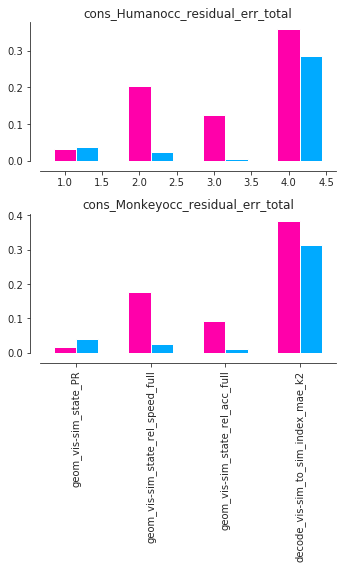

In [13]:

geom_fns = [
 'geom_vis-sim_state_PR',
 'geom_vis-sim_state_rel_speed_full',
 'geom_vis-sim_state_rel_acc_full',
]
predictor_metrics = geom_fns + ['decode_vis-sim_to_sim_index_mae_k2']
print(df_all.shape)
consistency_metrics = ['cons_Humanocc_residual_err_total', 'cons_Monkeyocc_residual_err_total']
f = plot_variance_exp_of_consistency(df_all, consistency_metrics, predictor_metrics, suffix=None, 
                                 plot_full_r2=False,plot_xlabels=True)
f.savefig('%s/var_exp_regularization_df_all.pdf' % figoutpath)

(192, 697)
Index(['cons_Humanocc_residual_err_total', 'geom_vis-sim_state_PR',
       'geom_vis-sim_state_rel_speed_full', 'geom_vis-sim_state_rel_acc_full',
       'decode_vis-sim_to_sim_index_mae_k2'],
      dtype='object')
                                   cons_Humanocc_residual_err_total  \
cons_Humanocc_residual_err_total                                  1   
geom_vis-sim_state_PR                                     0.0303213   
geom_vis-sim_state_rel_speed_full                          0.181344   
geom_vis-sim_state_rel_acc_full                            0.113284   
decode_vis-sim_to_sim_index_mae_k2                         0.357734   

                                   cons_Humanocc_residual_err_total  
cons_Humanocc_residual_err_total                                  0  
geom_vis-sim_state_PR                                     0.0157117  
geom_vis-sim_state_rel_speed_full                       7.37409e-10  
geom_vis-sim_state_rel_acc_full                         1.81225e-06

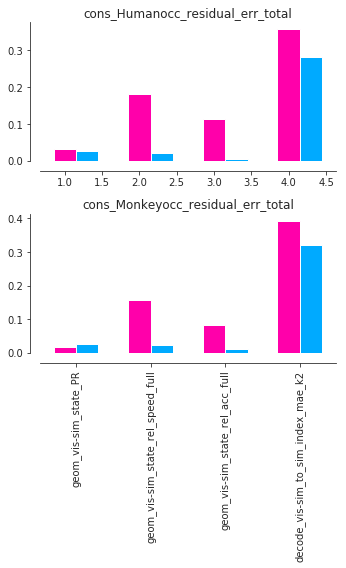

In [60]:
geom_fns = [
 'geom_vis-sim_state_PR',
 'geom_vis-sim_state_rel_speed_full',
 'geom_vis-sim_state_rel_acc_full',
#  'geom_vis-sim_state_raw_speed_full',
#  'geom_vis-sim_state_raw_acc_full',
#  'geom_vis-sim_state_raw_pos_full'
]
predictor_metrics = geom_fns + ['decode_vis-sim_to_sim_index_mae_k2']
print(df_base.shape)
consistency_metrics = ['cons_Humanocc_residual_err_total', 'cons_Monkeyocc_residual_err_total']
f = plot_variance_exp_of_consistency(df_base, consistency_metrics, predictor_metrics, suffix=None, 
                                 plot_full_r2=False,plot_xlabels=True)
f.savefig('%s/var_exp_regularization_df_base.pdf' % figoutpath)

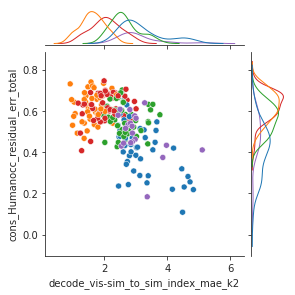

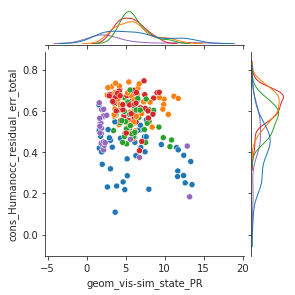

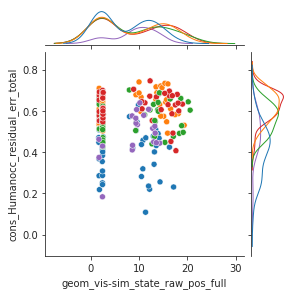

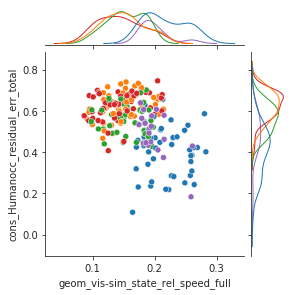

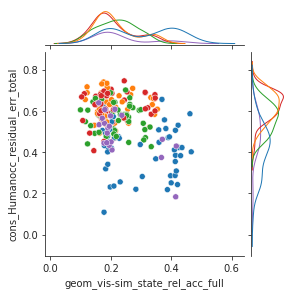

In [14]:
cons_metricn = 'cons_Humanocc_residual_err_total'
epoch = 'vis-sim'
state_fn = 'state'
rep_dim = 'full'
metrics = [
    'decode_vis-sim_to_sim_index_mae_k2', 
    'geom_%s_%s_PR' % (epoch, state_fn), 
    'geom_%s_%s_raw_pos_%s' % (epoch, state_fn, rep_dim),
    'geom_%s_%s_rel_speed_%s' % (epoch, state_fn, rep_dim),
    'geom_%s_%s_rel_acc_%s' % (epoch, state_fn, rep_dim), 
]

palette_reordered = current_palette[:5]

for x in metrics:
    y = cons_metricn
    g = sns.JointGrid(height=4)
    col_palette_2 = palette_reordered
    sns.scatterplot(data=df_all, x=x, y=y, hue="loss_weight_type", ax=g.ax_joint, 
                    legend=False, palette=col_palette_2)
    sns.kdeplot(data=df_all, x=x, linewidth=1, hue="loss_weight_type", ax=g.ax_marg_x, 
                legend=False, palette=col_palette_2)
    sns.kdeplot(data=df_all, y=y, linewidth=1, hue="loss_weight_type", ax=g.ax_marg_y, 
                legend=False, palette=col_palette_2)
    g.fig.savefig('%s/regularization_jointscatter_%s_v2.pdf' % (figoutpath, x))
    

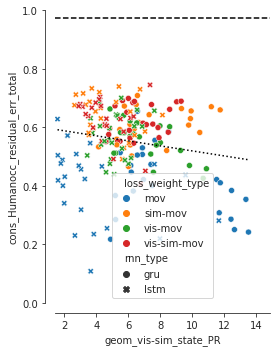

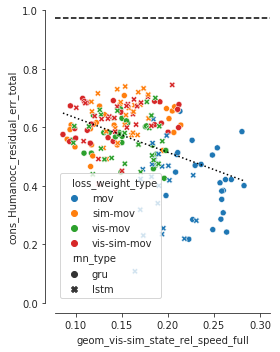

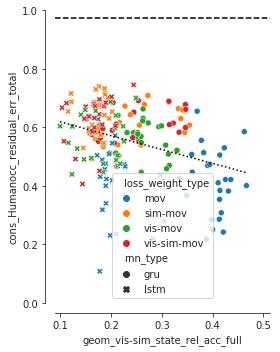

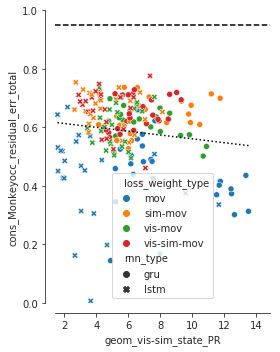

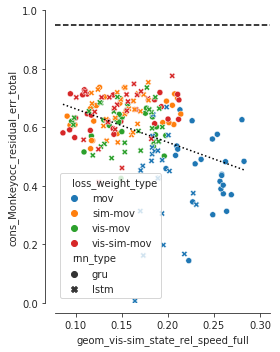

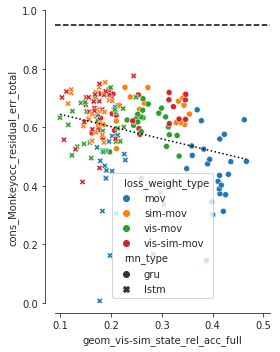

In [15]:
geom_fns = [
 'geom_vis-sim_state_PR',
 'geom_vis-sim_state_rel_speed_full',
 'geom_vis-sim_state_rel_acc_full',
]
predictor_metrics = geom_fns
consistency_metrics = ['cons_Humanocc_residual_err_total', 'cons_Monkeyocc_residual_err_total']
f,axes = plot_scatter_vs_consistency(df_base, consistency_metrics, predictor_metrics, suffix='scatter_regularization_df_base')